## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pickle
import simpy
import time
import pulp
import pandas as pd
import scipy.stats as stats

## Initializing data generation utilities

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

In [3]:
def nearest(X, P):
    minD = math.inf
    minP = None
    for p in P:
        for x in X:
            d=dist(x, p)
            if d<minD:
                minX, minP, minD = x, p, d
    return minX, minP         

In [4]:
def generateRandomGraph(n, x0, y0, r):

    def rounding(x):
        return int(math.floor(x/10))*10

    x0 = rounding(x0)
    y0 = rounding(y0)
    gridsize = rounding(r / math.sqrt(n) * 1.4)
    r = int(math.floor(r/gridsize))*gridsize
    split = int(2*r/gridsize)+1
    X = np.linspace(x0-r, x0+r, split)
    Y = np.linspace(y0-r, y0+r, split)
    P = [ (int(x), int(y)) for x in X for y in Y if dist((x,y), (x0,y0)) < r ]
    P = random.sample(P, k=n)
    
    E = []
    
    def addEdge(p, q):
        if p in P and q in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
    def addDiagonalEdge(p, q):
        (xp, yp) = p
        (xq, yq) = q
        if p in P and q in P and (xp, yq) not in P and (xq, yp) not in P and (p, q) not in E and (q, p) not in E:
            E.append((p, q))
            
    for (x, y) in P:
        addEdge( (x, y), (x, y+gridsize) )
        addEdge( (x, y), (x, y-gridsize) )
        addEdge( (x, y), (x+gridsize, y) )
        addEdge( (x, y), (x-gridsize, y) )
        addDiagonalEdge( (x, y), (x+gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x+gridsize, y-gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y+gridsize) )
        addDiagonalEdge( (x, y), (x-gridsize, y-gridsize) )
        
    return sorted(P), sorted(E)

In [ ]:
def plotGraph(P, E, col='b', grid=False):
    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in P ], [ p[1] for p in P ], col+'o', lw=1, ms=3)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], col+'-o', lw=1, ms=3)
    if grid:
        plt.grid()

In [5]:
def subgraph(P, E):
    P = P.copy()
    E = E.copy()
    PP = [ P[0] ] 
    EE = []
    P = P[1:]
    extended = True
    while extended:
        extended = False
        for (a, b) in E:
            if a in PP and b in P:
                PP.append(b)
                P.remove(b)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in P and b in PP:
                PP.append(a)
                P.remove(a)
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
            if a in PP and b in PP:
                EE.append((a, b))
                E.remove((a, b))
                extended = True
                break
    return PP, EE, P, E       

In [6]:
def generateGraph(n, x0, y0, r):
    P, E = generateRandomGraph(n, x0, y0, r)
    P0, _, P1, _ = subgraph(P, E)
    while len(P1)>0:
        (p, q) = nearest(P0, P1)
        E.append((p, q))
        P0, _, P1, _ = subgraph(P, E)
    return P, E

In [7]:
def splitEdgeRandomly(V, E, s):
    A, B = s
    p = random.uniform(0.3,0.7)
    x = int(A[0]+p*(B[0]-A[0]))
    y = int(A[1]+p*(B[1]-A[1]))
    t = (x,y)
    E.remove(s) 
    E.append((A, t))
    E.append((t, B))
    V.append(t)
    return (V, E), t

In [8]:
def generateRandomTargets(V, E, n=5):
    V, E = V.copy(), E.copy()
    T = []
    # we want to ensure that the beginning of the 
    # sequence of points generated randomly stays
    # the same
    mindist = 300
    while len(T)<n:
        s = random.choice(E)
        A, B = s
        if dist(A,B)>mindist: # avoid targets placed narrowly
            (V, E), t = splitEdgeRandomly(V, E, s)
            T.append(t)
    return sorted(T)

In [9]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

In [10]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=7,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ], 
                      styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8*maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

In [11]:
#main utility to generate data

In [12]:
#for generating data -imp

def generateData(seed=None, nodes=100, customers=150, 
                 plot=False, log=False):

    if seed is None:

        print("Usage:  M, C = generateData(seed=None, ")
        print("                            nodes=100, customers=50, ")
        print("                            plot=False, log=False)")
        print("")
        print("  seed  the seed value to be used for data generation. ")
        print("        To test the application use seed=0, it will create")
        print("        a small map, with a very few customer locations and")
        print("        a small set of delivery data.")
        print("")
        print("  nodes the number of intersections (vertices) in the generated map")
        print("")
        print("  customers  the number of customers generated on the map")
        print("")
        print("  log   Controls print output during data generation.")
        print("")
        print("  plot  Controls graphical output during data generation.")
        print("")
        print("Returns:")
        print("")
        print("  M = (V, E) is the generated map given as a graph")
        print("    where V is a list of vertices, with each vertice ")
        print("    given as a pair (x, y) of integer coordinates, ")
        print("    and E is a list of edges, with each edge given")
        print("    as a pair (A, B) of vertices, with each vertex again")
        print("    given as a pair (x, y) of integer coordinates")
        print("")
        # print("  W ∈ V  is the location of the distribution warehouse")
        # print("    given as a pair (x, y) of integer coordinates")
        # print("")
        print("  C is a list of customer locations")
        print("    given as pairs (x, y) of integer coordinates on or near")
        print("    existing edges E. To integrate a set of customer locations")
        print("    into a given map M = (V, E), use addTarget(M, C)")
        print("")
        
        seed = 0
    
    if seed==0:          # generate very simple test data 
        nodes = 20       # number of points in map
        customers = 5    # number of  customers
        grid = True
            
    else:
        grid = False
        
    random.seed(seed)
    
    V, E = generateGraph(nodes, 4000, 4000, 4000)
    
    C = generateRandomTargets(V, E, customers)

    if log:
        print(f"Generated map with {nodes:d} nodes and " 
              f"{customers:d} customer locations")
    if plot:
        label="" if seed==0 else f"seed={seed:4d}"
        plotMap((V, E), T=C, text=label, grid=grid)
    
    return (V, E), C


## Initializing Plotting Utilities

In [13]:
def histplot(data, title="", xlabel="",
             width=None, height=None):
    
    minx = min(data)
    maxx = max(data)
    μ = np.mean(data)
    σ = np.std(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 4)
    fig.set_figheight(height if height is not None else 2.5)
    ax = fig.gca()
        
    bins=(maxx-minx)//5+1
    hist=plt.hist(data, density=True, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(title)
        
    x = np.linspace(minx, maxx, 100)
    y = [ stats.norm(loc=μ, scale=σ).pdf(p) for p in x]
    ax.plot(x, y, lw=1, color='red')
    ax.axvline(x=μ, color='red')
    maxy = max(max(y), max(hist[0]))
    ax.text(maxx, maxy, 
            f'μ={μ:2.2f}\nσ={σ:2.2f}', 
            ha='right', va='top', 
            color='red', fontsize=12)
    ax.grid(True)
    plt.show()

In [14]:
def dailyPlot(data, 
              title="", ylabel="",
              width=None, height=None):
    
    days = len(data)
    
    fig = plt.figure()
    fig.set_figwidth(width if width is not None else 6)
    fig.set_figheight(height if height is not None else 2)
    
    ax = fig.gca()
    diff = (max(data)-min(data))*0.1
    ymin = int(math.floor(min(data)-diff))
    ymax = int(math.ceil(max(data)+diff))
    ax.set_xlim(-1, days)
    ax.set_ylim(ymin, ymax)
    ax.grid(True)
    
    ms = 2 if len(data)>100 else 5
    lw = 0.5 if len(data)>100 else 1

    x = np.arange(0, len(data))
    y = np.array([ y for y in data ])
    b, m = np.polynomial.polynomial.polyfit(x, y, 1)
    
    plt.plot(x, y, 'bo-', linewidth=lw, markersize=ms)
    plt.plot(x, m*x+b, 'r-')
    
    plt.xlabel('Day')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Step 1 : Generate test data

Generated map with 100 nodes and 150 customer locations


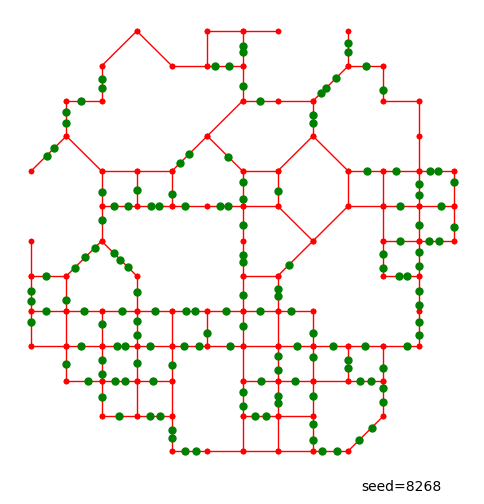

In [15]:
seed=8268
data = generateData(seed, plot=True, log=True)

In [16]:
#save test data for customer locations
with open('customer_data.pickled', 'wb') as f:
    pickle.dump(data, f)

### 1.1 Generate Delivery Data function

In [17]:
## generating delivery data according to specification in assignment

def generateDeliveryData(p, C, days, seed=0):
    ## p is the average number of parcels per day per customer
    ## C is the number of customers to be served
    ## days is the number of days for which data are to be generated.
    np.random.seed(seed)
    R = np.random.poisson(lam=len(C)*p, size=days)
    D = [ sorted(list(np.random.choice(range(len(C)), size=i))) for i in R ]
    return D

### 1.2 Generate Warehouse Location

In [18]:
#for generating a single random warehouse location from Map()
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]#1 sample
    return W

## Step 2 : Trip and Path Utilities

### 2.1 Path

In [19]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [20]:
# A* algorithm for shortest path
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

### 2.2 Shortest delivery route utilities

In [21]:
def reverse(P):
    return [ P[-i] for i in range(1,len(P)+1) ]
    
def index(x, L):
    for i in range(len(L)):
        if x==L[i]: 
            return i
    return None

In [22]:
def createTables(M, T):
    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [23]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [24]:
def createLoop(M, T):
    D, P = createTables(M, T)
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    # print(f"{constraints:d} Constraints")
    prob.solve(solver)
    trips = roundtrips(x, n)
    while len(trips)>1:
        for t in trips:
            prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                            for i in range(0,len(t)-1) ]) <= len(t)-2
            constraints += 1
        # print(f"{constraints:d} Constraints")
        prob.solve(solver)
        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
    return loop

## Step 3 : Time Handling Utilities

**Convention:** In this project we measure time in seconds. The simulation will start at 0:00. Time related methods will be added as they are needed.

`timestamp(t)` generates a timestamp string in the form `[dd] hh:mm:ss.d`

In [25]:
def timestamp(t):
    day = int(t)//(24*3600)
    t = t - day*24*3600
    hour = int(t)//3600
    t = t - hour*3600
    mins = int(t)//60
    t = t - mins*60
    secs = int(t)
    t = int(round((t - secs)*10))
    return f"[{day:2d}] {hour:02d}:{mins:02d}:{secs:02d}.{t:1d}"

In [26]:
timestamp(24*3600*3+17*3600+615.1)

'[ 3] 17:10:15.1'

In [27]:
def nextHour(env, hour):
    beginningOfDay = int(env.now//(24*3600))*24*3600
    timeOfDay = env.now-beginningOfDay
    if hour*3600 > timeOfDay:
        return hour*3600 - timeOfDay
    else:
        return hour*3600 + 24*3600 - timeOfDay

In [28]:
def day(now):
    return int(now//(24*3600))

## Step 4: Simulation Data Capturing Utilities

We will use a class Recorder as a reference point for capturing data during the simulation. There will be only one recorder. It will be created at the beginning of every simulation run. Every entity will carry a reference to the Recorder.

### 4.1 Class Recorder

In [29]:
class Recorder:
    
    def __init__(self, env, M, W, C, days, 
                 log=False, plot=False, timing=False):
        self.env = env
        self.M = M
        self.W = W
        self.C = C
        self.days = days
        self.log = log
        self.plot = plot
        
        self.timing = timing
        self.start_time = time.time()
        self.last_time = self.start_time
        self.cum_timer = {}

        Customer.REGISTER = []
        Parcel.REGISTER = []

        # created a data frame for records per working day
        self.daily = pd.DataFrame()
        self.daily['begin work at'] = [None]*days
        self.daily['end work at'] = [None]*days
        self.daily['dist'] = [None]*days
        self.daily['left'] = [None]*days

    def timer(self, s):
        t = time.time()
        Δt = t-self.last_time
        if self.timing:
            print(f"==== t: {t-self.start_time:6.2f}s "
                  f"Δt: {Δt:6.2f}s [{s:s}]")
        if s in self.cum_timer:
            self.cum_timer[s] += Δt
        else:
            self.cum_timer[s] = Δt
        self.last_time = t

    def reportTimer(self):
        print(f"==== t: {self.total_time:6.2f}s Total")
        for k in sorted(self.cum_timer, key=lambda x: self.cum_timer[x], reverse=True):
            print(f"==== ΣΔt: {self.cum_timer[k]:6.2f}s "+ k)

    def trace(self, event):
        if self.log:
            print(timestamp(self.env.now), event)

    def recordDriverBeginsWork(self):
        self.trace("Driver arrives for work")
        self.daily.at[day(self.env.now), 'begin work at'] = int(round(self.env.now))
        
    def recordDriverEndsWork(self):
        self.trace("Driver goes home")
        self.daily.at[day(self.env.now), 'end work at'] = int(round(self.env.now))
    
    def recordTourLength(self, length):
        self.daily.at[day(self.env.now), 'dist'] = int(length)

    def recordParcelsLeftOver(self, numberOfParcels):
        self.trace(f"{numberOfParcels:d} left over for next day")
        self.daily.at[day(self.env.now), 'left'] = numberOfParcels

    def finish(self):
        self.total_time = time.time()-self.start_time
        self.daily['working time'] = (self.daily['end work at']-self.daily['begin work at'])//60
        # simulation is finished for good
        # by removing the simulation environment we can
        # pickle recorder
        self.env = None
        
    def __stats__(self, column):
        d = self.daily[column].copy()
        return d.mean(), d.median(), d.std()
        
    def statsWorkingTime(self):
        return self.__stats__('working time')
        
    def histWorkingTime(self):
        histplot(self.daily['working time'],
                 xlabel='Working Time [min]',
                 title='Daily Working Time')
        
    def plotWorkingTime(self):
        dailyPlot(self.daily['working time'],
                  ylabel='Working Time [min]',
                  title='Daily Working Time')

    def statsTourLength(self):
        return self.__stats__('dist')
        
    def histTourLength(self):
        histplot(self.daily['dist'],
                 xlabel='Tour Length [m]',
                 title='Daily Tour Length')
            
    def plotTourLength(self):
        dailyPlot(self.daily['dist'],
                  ylabel='Tour Length [m]',
                  title='Daily Tour Length')

    def statsLeftOver(self):
        return self.__stats__('left')
        
    def histLeftOver(self):
        histplot(self.daily['left'],
                 xlabel='Left-Over Parcels',
                 title='Daily Left-Over Parcels')
                
    def plotLeftOver(self):
        dailyPlot(self.daily['left'],
                  ylabel='Number of Parcels',
                  title='Daily Left-Over Parcels')

### 4.2 Class Parcel

Parcels follow through a sequence of states:
- processing
- in transit (from manufacture to distribution centre)
- arrived in distribution centre
- ready for delivery 
- out for delivery
- customer not present
- returned to distribution centre
- delivered

In [30]:
class Parcel:
    
    REGISTER = []
    
    def __init__(self, rec, i, cust, custIndex):
        self.rec = rec
        self.i = i  # row index in data frames of input data
        self.dest = cust.location
        self.custIndex = custIndex
        self.status = [ 'processing' ] # status record and
        self.timing = [ self.rec.env.now ]      # timing
        assert(len(Parcel.REGISTER)==i)
        Parcel.REGISTER += [ self ] 
    
    # factory method ensures that there is only
    # one Parcel per location
    def getParcel(rec, i, location, custIndex):
        for p in Parcel.REGISTER:
            if p.i == i:
                return p
        return Parcel(rec, i, location, custIndex)

    
    def __str__(self):
        return f"Parcel: {self.i:3d} ({self.custIndex:3d})"

    def index(self):
        return self.i
    
    def destination(self):
        return self.dest
    
    def __reg(self, state):
        self.status += [ state ]
        self.timing += [ self.rec.env.now ]
        self.rec.trace(str(self)+" "+state)
        
    def arrivedAtDeliveryCentre(self):
        self.__reg('arr at delivery centre')
        
    def outForDelivery(self): 
        self.__reg('out for delivery')
        
    def returnFromDelivery(self):
        self.__reg('return from delivery')
    

### 4.3 Class Customer

In [31]:
class Customer:
    
    REGISTER = []

    def __init__(self, rec, location):
        self.rec = rec
        self.location = location
        self.i = len(Customer.REGISTER)
        Customer.REGISTER += [ self ]
        self.atHome = True
        self.answersDoor = False
        self.parcelsReceived = []
        rec.env.process(self.process())
        
    def __str__(self):
        return f"Customer: {self.i:2d} {str(self.location):s}"
    
    # factory method ensures that there is only
    # one customer per location
    def getCustomer(rec, location):
        for c in Customer.REGISTER:
            if c.location == location:
                return c
        return Customer(rec, location)
    
    def leaveHouse(self):
        assert(self.atHome and not self.answersDoor)
        # self.rec.trace(str(self)+" leaves house")
        self.atHome = False
     
    def returnHome(self):
        assert(not self.atHome)
        # self.rec.trace(str(self)+" returns home")
        self.atHome = True
        
    def answerDoor(self):
        if self.atHome:
            yield self.rec.env.timeout(random.expovariate(1/AVERAGE_TIME_ANSWER_DOOR))
            self.rec.trace(str(self)+" answers door")
            self.answersDoor = True
        else:
            yield self.rec.env.timeout(WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR)
            self.rec(str(self)+" not at home")
            
    def acceptParcel(self, parcel):
        assert(self.answersDoor)
        self.parcelsReceived += [parcel]
        self.rec.trace(str(self)+" accepts "+str(parcel))
        
    def signOff(self):
        assert(self.answersDoor)
        self.rec.trace(str(self)+" signs off")
        self.answersDoor = False
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 8))
        while day(self.rec.env.now)<self.rec.days:
            # in a refinement we may use random times
            self.leaveHouse()
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))
            self.returnHome()
            yield self.rec.env.timeout(nextHour(self.rec.env, 8))

### 4.4 Class Driver

In [32]:
class Driver:
    
    def __init__(self, rec, DC):
        self.rec = rec
        self.DC = DC
        self.location = None
        self.parcels = None
        self.tour = None
        self.rec.env.process(self.process())
        
    # activity
    def __drive(self, target):
        assert(self.tour[0] == self.location)
        while self.location!=target:
            d = dist(self.location, self.tour[1])
            yield self.rec.env.timeout(d / AVERAGE_SPEED)
            self.location = self.tour[1]
            self.tour = self.tour[1:]
        assert(self.tour[0] == self.location == target)
    
    def arriveForWork(self):
        self.location = self.DC.W
        self.parcels = []
        self.returns = []
        self.tour = [ self.DC.W ]
        self.rec.recordDriverBeginsWork()
        
    def leaveForDelivery(self, tour, parcels):
        self.tour, self.parcels = tour, parcels
        self.rec.trace(f"Driver leaves for delivery " \
                       f"of {len(parcels):d} parcels")
        
    def process(self):
        yield self.rec.env.timeout(nextHour(self.rec.env, 18))
        while day(self.rec.env.now)<self.rec.days:
            self.arriveForWork()
            tour, parcels = self.DC.sendForDelivery()
            yield self.rec.env.timeout(PREP_TIME_PER_PARCEL*len(parcels))
            self.rec.recordTourLength(pathLength(tour))
            self.leaveForDelivery(tour, parcels)        
            while len(self.parcels)>0:
                # drive to customer
                custLocation = self.parcels[0].dest
                cust = Customer.getCustomer(self.rec, custLocation)
                self.rec.trace("Driver drives to "+str(cust))
                yield from self.__drive(custLocation)
                self.rec.trace("Driver arrived at "+str(cust))
                # call at customer
                yield from cust.answerDoor()
                
                if cust.answersDoor:
                    while len(self.parcels)>0 and \
                            custLocation == self.parcels[0].dest:
                        cust.acceptParcel(self.parcels[0])
                        yield self.rec.env.timeout(random.expovariate(1/10))
                        self.parcels = self.parcels[1:]
                    cust.signOff()
                    yield self.rec.env.timeout(random.expovariate(1/10))
                else:
                    while len(self.parcels)>0 and  \
                            custLocation == self.parcels[0].dest:
                        self.returns += self.parcels[0]
                        self.parcels = self.parcels[1:]

            # return to delivery centre
            self.rec.trace("Driver returns to delivery centre")
            yield from self.__drive(self.DC.W)
            self.rec.trace("Driver arrived at delivery centre")
            
            for parcel in self.returns:
                self.DC.returnFromDelivery(parcel)
                yield self.rec.env.timeout(RETURN_TIME_PER_PARCEL)
            yield self.rec.env.timeout(600)
                    
            self.rec.recordParcelsLeftOver(len(self.DC.parcels)+
                                           len(self.DC.leftOver))

            self.rec.recordDriverEndsWork()
            
            self.rec.trace(self.DC.inventory())
            
            yield self.rec.env.timeout(nextHour(self.rec.env, 18))

### 4.5 Class Delivery Centre

In [33]:
class DeliveryCentre:
    
    def __init__(self, rec, M, W):
        self.rec = rec
        self.M = M
        self.W = W
        self.limit = 35000
        
        
        self.leftOver = []    # list of parcels
        self.parcels = []     # list of parcels scheduled for delivery
        self.dest = []        # list of unique customer destinations
        self.tour = [W]       # tour planned for delivery
        
    def __accept(self, parcel):
        custLoc = parcel.dest
        if custLoc not in self.dest:
            start_time = time.time()
            MT = addTargets(self.M, self.dest + [custLoc])
            self.rec.timer("addTarget")
            S = createLoop(MT, [self.W] + self.dest + [custLoc])
            self.rec.timer("createLoop")
            if pathLength(S)<self.limit:
                self.parcels.append(parcel)
                self.dest += [custLoc]
                self.tour = S
            else:
                self.leftOver.append(parcel)
        else:
            self.parcels.append(parcel)
        
    def acceptParcel(self, parcel):
        parcel.arrivedAtDeliveryCentre()
        self.__accept(parcel)
            
    def sendForDelivery(self):
        parcels = []
        tour = self.tour
        addresses = self.dest
        
        # pick parcels in sequence to be delivered
        for i in range(1, len(tour)-1):
            dest = tour[i]
            for p in self.parcels:
                if p.dest == dest and p not in parcels:
                    parcels += [p]
                    p.outForDelivery()
         
        # arrange the left overs
        L = self.leftOver
        self.tour = [self.W]
        self.parcels = []
        self.leftOver = []
        self.dest = []
        for p in L:
            self.__accept(p)
        
        if self.rec.plot:
            plotMap(self.rec.M, T=addresses, P=tour, W=tour[0], 
                    text=f"Day {day(self.rec.env.now):2d}, {pathLength(tour):,d}m")

        return tour, parcels
                 
    def returnFromDelivery(self, parcel):
        parcel.returnFromDelivery()
        self.__accept(parcel)

    def getInventory(self):
        acc = ""
        for p in self.parcels:
            if len(acc)>0:
                acc += ", "
            acc += f"{p.custIndex:d}"
        acc += " / "
        for p in self.leftOver:
            if len(acc)>0:
                acc += ", "
            acc += f"{p.custIndex:d}"
        return acc
        
    def inventory(self):
        return f"Delivery Centre Inventory: " \
               f"{len(self.parcels)+len(self.leftOver):d}"

## Step 5 : Simulation

### 5.1 Parameters from Specification

The time required for driving is based on the distance between way points at an average speed of 15km/h.

In [34]:
AVERAGE_SPEED = 15/3.6

The **cumulative preparation time** (route planning and 
sorting of the parcels in the delivery order and 
packing the cargo-bike) is assumed to be 50 sec per 
parcel to be delivered.

In [35]:
PREP_TIME_PER_PARCEL = 50

**Additional assumption:** The time to **process returned parcels** in the delivery centre is 30 sec per parcel. 

In [36]:
RETURN_TIME_PER_PARCEL = 30

The average time to answer the door.

In [37]:
AVERAGE_TIME_ANSWER_DOOR = 40

In [38]:
WAIT_TIME_IF_CUSTOMER_DOESNT_ANSWER_DOOR = 60

Now, we will use the Delivery data generated for simulation earlier for the coming steps. 

### 5.2 Generate input data for simulation

In [39]:
## generate input data for simulation
def generateInputData(D, log=False):

    R = [ len(d) for d in D ]
    N = sum(R)
    
    DAY_LENGTH = 24*3600    # measured in minutes
    DAY_START = 8*3600      # first delivery in the morning
    DAY_END = 17*3600     # last delivery during day time

    x = pd.DataFrame()

    x['iarr'] = [None]*N
    x['time'] = [None]*N
    x['day'] = [None]*N
    x['dest'] = [None]*N

    current_day = 0
    last_time = 0
    i = 0

    for d in D: # for each day

        if log:
            print("generating for day: ",current_day, D[current_day])
            
        time = current_day*DAY_LENGTH + DAY_START 

        for c in d: # for each customer that should get a 

            IARR = (DAY_END-DAY_START-2*3600) / len(d)  # estimated average IAT for the current day

            iat = random.expovariate(1.0/IARR)
            new_time = time + iat

            x.at[i, 'iarr'] = round(new_time - last_time,1)
            x.at[i, 'time'] = round(new_time - current_day*DAY_LENGTH , 1)
            x.at[i, 'day'] = current_day
            x.at[i, 'dest'] = c
            
            i += 1
            last_time = time = new_time
    
        current_day += 1
    
    return x

### 5.3 Simulation Routine

In [40]:
def simulation(M, W, C, p=0.2, days=10, seed=0, 
               title=None, log=False, plot=False, timing=False):

    if timing:
        start_time = time.time()
        
    random.seed(seed)
    D = generateDeliveryData(p, C, days, seed)
    X = generateInputData(D, log=log)
    
    env = simpy.Environment()
    rec = Recorder(env, M, W, C, days, log=log, plot=plot, timing=timing)

    if title is not None:
        print(title)
    else:
        print(f"Simulating delivery of {len(X):d} parcels "
              f"over {len(D):d} days to {len(C):d} customers")

    for c in C:
        Customer.getCustomer(rec, c)           
    DC = DeliveryCentre(rec, M, W)
    D = Driver(rec, DC)

    def generatorProcess(env):
        # generate the parcels based on input data x
        for i in range(len(X)):
            yield env.timeout(X.at[i, 'iarr'])
            custIndex = X.at[i, 'dest']
            custLoc = C[custIndex]
            cust = Customer.getCustomer(rec, custLoc)
            p = Parcel.getParcel(rec, i, cust, custIndex)
            DC.acceptParcel(p)

    env.process(generatorProcess(env))
    env.run()

    if log:
        print(DC.inventory())

    rec.finish()
    return rec

## Step 6 : Optimisation

In [41]:
import os

def generateWarehouseLocations(M, p):

    def numberOfEdges(v, E):
        count = 0
        for e in E:
            if e[0]==v or e[1]==v:
                count += 1
        return count

    V, E = M
    W = [ v for v in V if numberOfEdges(v, E)>2 ]
    return random.sample(W, k=int(round(len(W)*p)))

def formatLocation(w):
    return f"({w[0]:4d},{w[1]:4d})"
    
def objectiveFunction(w, seed,days,p):
    random.seed(seed)
    title = "Simulate Delivery from Warehouse "+formatLocation(w)
    rec = simulation(M, w, C, p=p, days=days, title=title)
    filename = "recorder/rec_w="+formatLocation(w)+".pickled"
    
    # Check if directory exists, if not, create it
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(filename, 'wb') as f:
        pickle.dump(rec, f)
    return rec.statsTourLength()[0] # mean tour length


def monteCarlo(M, p, days,seed):#changed

    W = generateWarehouseLocations(M, p)
    plotMap(M, T=W, styleT='bo', msT=7, 
            text="Warehouse Candidate Positions")

    minW, minP = None, math.inf
    for w in W:
        f = objectiveFunction(w,seed,days,p)#added p
        if f < minP:
            print(f"  improved position:   {formatLocation(w):s} f={f:7.2f}")
            minW, minP = [w], f
        elif f == minP:
            print(f"  equivalent position: {formatLocation(w):s} f={f:7.2f}")
            minW.append(w)
            
    return minW

In [42]:
#open test data
with open('customer_data.pickled', 'rb') as f:
    M, C = pickle.load(f)

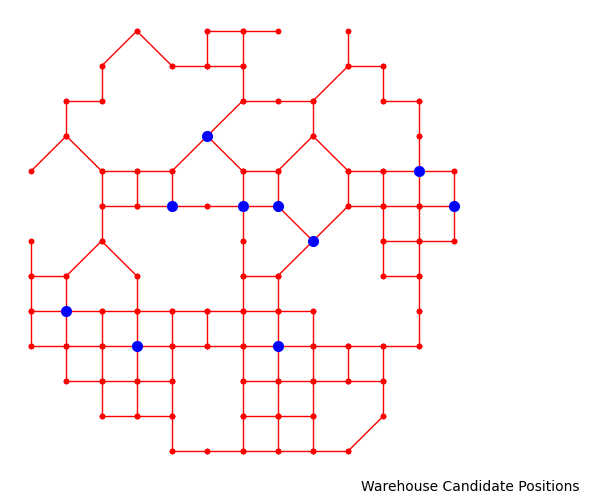

Simulate Delivery from Warehouse (6800,5120)
  improved position:   (6800,5120) f=31822.20
Simulate Delivery from Warehouse (4000,4560)
  improved position:   (4000,4560) f=31681.20
Simulate Delivery from Warehouse (5120,4000)
Simulate Delivery from Warehouse (4560,4560)
Simulate Delivery from Warehouse (2320,2320)
  improved position:   (2320,2320) f=31444.50
Simulate Delivery from Warehouse (4560,2320)
Simulate Delivery from Warehouse (7360,4560)
Simulate Delivery from Warehouse (1200,2880)
  improved position:   (1200,2880) f=31428.50
Simulate Delivery from Warehouse (3440,5680)
Simulate Delivery from Warehouse (2880,4560)


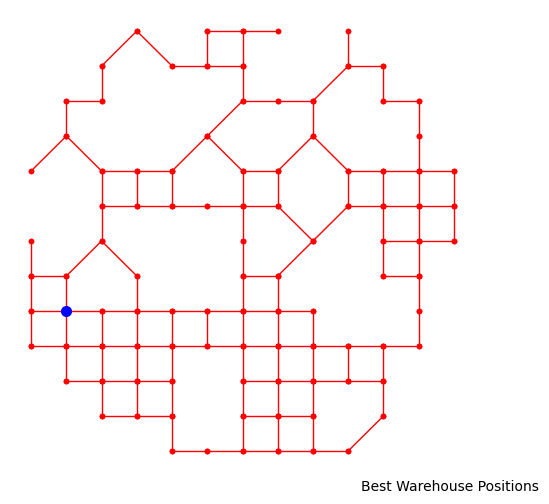

In [43]:
seed=8268# for warehouse locations
random.seed(seed)
W = monteCarlo(M, p = 0.15, days=10 ,seed=seed)#changed p to 0.15
plotMap(M, T=W, styleT='bo', msT=7, text='Best Warehouse Positions')

In [49]:
#open test data
with open(r'recorder/rec_w=(1200,2880).pickled', 'rb') as f:
    recorder_optimised=pickle.load(f)

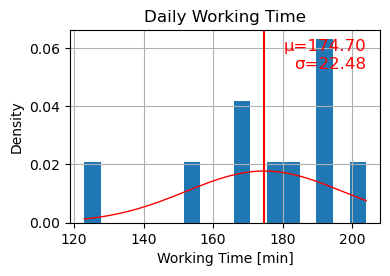

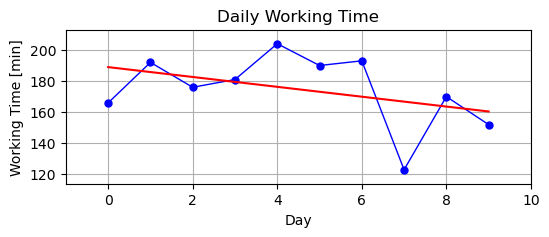

(174.7, 178.5, 23.69739788809452)

In [50]:
recorder_optimised.histWorkingTime()
recorder_optimised.plotWorkingTime()
recorder_optimised.statsWorkingTime()

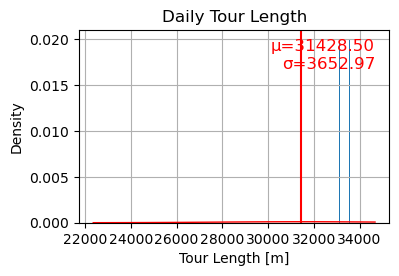

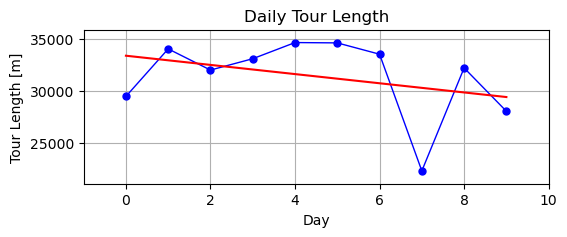

(31428.5, 32681.0, 3850.563284911847)

In [51]:
recorder_optimised.histTourLength()
recorder_optimised.plotTourLength()
recorder_optimised.statsTourLength()

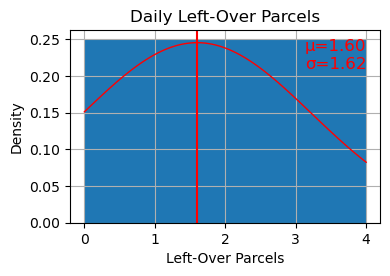

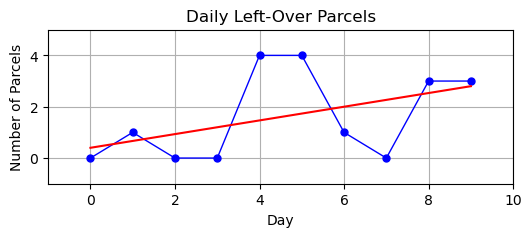

(1.6, 1.0, 1.7126976771553508)

In [52]:
recorder_optimised.histLeftOver()
recorder_optimised.plotLeftOver()
recorder_optimised.statsLeftOver()

In [ ]:
recorder_optimised.reportTimer()

In [ ]:
recorder_optimised.tableParcelDelay()
recorder_optimised.barplotParcelDelay()

In [ ]:
recorder_optimised.plotLeftOver()